# Reana-SPL Data Analysis

This repository contains execution data and analysis for persistent variations of the [Reana-SPL](https://github.com/SPLMC/reana-spl) tool.

# SPL Analysis Approach

Reana-SPL performs a product-line reliability analysis on a variety of software-product-lines.

To leverage the commonality among different products in order to speed up analysis,
we use a [feature-family-based analysis](https://www.infosun.fim.uni-passau.de/publications/docs/LCA+17ist.pdf). Instead of enumerating products and analyzing
them one-by-one (product-based analysis), we analyze features in isolation
and exploit the commonality among products to get results for the entire
product space more efficiently.

We analyze the data of three approaches to handling the evolved models.
- Non-evolution-aware: The analysis tool does not do any
  special handling of evolved models.
- Evolution-aware without reordering: The analysis tool handles evolved models
  by reusing ADDs generated in previous runs.
  ADDs are only automatically reordered in the first run.
- Evolution-aware with reordering: Same as the above, but ADDs are reordered
  automatically at each iteration.

We expect the non-evolution-aware analysis to perform the worst, with
both evolution-aware approaches obtaining similar results.
There is a tradeoff to ADD reordering: while it is expensive, it obtains
smaller ADDs on which operations are easier to perform.

# Data 

The data used contains runtime information for different variations of the
[Reana-SPL](https://github.com/SPLMC/reana-spl) product line analysis tool.
Different approaches are implemented in different branches of the main repository.
The main difference in the implementations is in the handling of ADD persistence.
The non-evolution-aware does not save its generated ADDs nor does it read ADDs
from previous executions, as is done in the evolution-aware implementations.

We execute an evolution scenario on the initial models of 6 different product
lines (BSN, Email, IC, Lift, MP, TW).
Each evolution doubles the amount of products to be analyzed.
Each model is evolved in a fixed manner up to 22 times, so we have an
increase in the product space of up to \(2^21\)-fold


In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as iter
from tabulate import tabulate
from scipy.stats import *

In [121]:
def out_to_csv(in_filename, out_filename):
    data = []
    i = -1
    with open(in_filename) as in_f:
        lines = in_f.readlines()
    for line in lines:
        if not isNumber(line):
            i += 1
            data.append([])
        else:
            data[i].append(float(line))
    with open(out_filename, 'w') as out_f:
        for i in range(len(data)):
            for j in range(len(data[i])):
                if j == len(data[i])-1:
                    out_f.write("{}\n".format(data[i][j]))
                else:
                    out_f.write("{},".format(data[i][j]))
        
    
def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [97]:
def _read_data(spl, filenames, labels, factor=1.0):
    dfs = []
    for filename in filenames:
        df = pd.read_csv(filename, header=None).transpose()
        dfs.append(df)

    # delete extra rows (to match sample sizes)
    n = min([df.shape[0] for df in dfs])
    for df in dfs:
        if df.shape[0] > n:
            rows = list(range(n, df.shape[0]))
            df = df.drop(rows, inplace=True) 
        
    df = pd.concat(dfs, keys=types)
    df *= factor
    
    return df, n

def read_data(spl, filenames, labels, factor=1.0):
    df, n = _read_data(spl, filenames, labels, factor=factor)
    df['Type'] = np.repeat(labels, np.repeat([n], len(labels)), axis=0)
    return df

In [91]:
def make_line_graph(df, spl, labels, yscale='linear', xlabel='x', ylabel='y', filename=None):

    means = []
    stds = []

    for label in labels:
        dfl = df.loc[label]
        means.append(np.mean(dfl))
        stds.append(np.std(dfl))
    
    df_mean = pd.concat(means, keys=labels)
    df_std = pd.concat(stds, keys=labels)
    
    plt.figure(figsize=(12,5)) # TODO: is this OK?
    
    axs = []

    for i in range(len(labels)):
        label = labels[i]
        if i == 0:
            ax = df_mean[label].plot(grid=True, yerr=df_std[label], label=label)
        else:
            ax = df_mean[label].plot(grid=True, secondary_y=False, yerr=df_std[label], label=label)

        axs.append(ax)

    xticks = np.arange(0, df_mean[types[0]].shape[0], 1)

    for ax in axs:
        ax.set_xticks(xticks)
    
    # plt.legend(h1+h2, l1+l2, loc=2)
    plt.legend()
    plt.yscale(yscale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(spl)
    if filename is not None:
        plt.savefig(filename)
        
    plt.show()

In [127]:
def make_box_plot(df, spl, title=None, xlabel='', ylabel='', filename=None):
    means = np.mean(df)
    stdevs = np.std(df)
    fig, ax_new = plt.subplots(5, 5, sharex=False, sharey=False, figsize=(20,20))
    
    # these magics work for 5 by 5 plots, which is appropriate for our current data dimensions
    i = 4
    j = 4
    while i * 5 + j + 1 > len(means):
        fig.delaxes(ax_new[i, j])
        if j == 0:
            j = 4
            i -= 1
        else:
            j -= 1

    bp = df.boxplot(by="Type",ax=ax_new.flatten()[:len(means)], figsize=(6,8))

    for i in range(len(means)):
        ax_new.flatten()[i].autoscale()
        ax_new.flatten()[i].set_xlabel(xlabel)
        ax_new.flatten()[i].set_ylabel(ylabel)
    
    if title is None:
        title = spl

    fig.suptitle(title)
    
    if filename is not None:
        plt.savefig(filename)

    plt.show()

In [11]:
def get_extended_df(spl):
    df, _ = _read_data(spl)

    reana_means = np.mean(df.loc['reana'])
    reana_std = np.std(df.loc['reana'])

    reanae_means = np.mean(df.loc['reanaE'])
    reanae_std = np.std(df.loc['reanaE'])

    reanaeord_means = np.mean(df.loc['reanaEord'])
    reanaeord_std = np.std(df.loc['reanaEord'])

    dfe = pd.DataFrame()
    dfe['means'] = pd.concat([reana_means, reanae_means], keys=['reana', 'reanaE', 'reanaEord'])
    dfe['std'] = pd.concat([reana_std, reanae_std], keys=['reana', 'reanaE', 'reanaEord'])
    return dfe

In [27]:
def is_normally_distributed(samples, significance=0.01):
    x, p = normaltest(samples)
    return p >= significance

def compare_samples(s1, s2, significance=0.01):
    if (is_normally_distributed(s1, significance=significance)
        and is_normally_distributed(s2, significance=significance)):
        # both normally distributed
        _, p1 = bartlett(s1, s2)                                 # test variances
        _, p2 = ttest_ind(s1, s2, equal_var=p1 >= significance)  # equal variances is assumed unless stated otherwise
        method = 'T-test' if p1 >= significance else 'Welch'     # from ttest_ind's documentation
        return (p2 >= significance, method, p1, p2)
    else:
        # not both normally distributed
        u, p = mannwhitneyu(s1, s2, use_continuity=False)
        return (p >= significance, 'Mann-Whitney', u, p)

In [108]:
def test(df, t1, t2):
    n = get_num_evolutions(df)
    for i in range(n):
        reana_samples = get_evolution_samples(df, i, label=t1)
        reanae_samples = get_evolution_samples(df, i, label=t2)
        result = compare_samples(reana_samples, reanae_samples)
        print('{}\t{}'.format(i, result))

def get_num_evolutions(df):
    label = df['Type'][0]
    return df.loc[label].shape[1] - 1  # exclude type column

def get_evolution_samples(df, n, label):
    return df.iloc[:][n].loc[type]

In [122]:
def concat(lists):
    return list(iter.chain.from_iterable(lists))

spls = ['BSN', 'Email', 'IC', 'Lift', 'MP', 'TW']
labels = ['Reana', 'ReanaE']

rt_data = concat([['running_time/totalTime{}{}'.format(spl, label) for spl in spls] for label in labels])
mem_data = concat([['memory_usage/totalMemory{}{}'.format(spl, label) for spl in spls] for label in labels])


for filename in rt_data:
    out_to_csv('data/{}.out'.format(filename), 'csv/{}.csv'.format(filename))

for filename in mem_data:
        out_to_csv('data/{}.out'.format(filename), 'csv/{}.csv'.format(filename))

In [134]:
def plot_spl(spl):
    rt_labels = ['Reana', 'ReanaE', 'ReanaEord']
    mem_labels = ['Reana', 'ReanaE']

    rt_filenames = ['csv/running_time/totalTime{}{}.csv'.format(spl, label) for label in rt_labels]
    mem_filenames = ['csv/memory_usage/totalMemory{}{}.csv'.format(spl, label) for label in mem_labels]

    rt_df = read_data(spl, rt_filenames, rt_labels, factor=1/1000.0) # factor converts from ms to s
    mem_df = read_data(spl, mem_filenames, mem_labels)
    make_line_graph(rt_df, spl, rt_labels, xlabel='Evolution', ylabel='Running Time(s)', yscale='log')    
    make_line_graph(mem_df, spl, mem_labels, xlabel='Evolution', ylabel='Memory Usage (MB)', yscale='log')  

    make_box_plot(rt_df, spl, title='{}: Running Time (s)'.format(spl))
    make_box_plot(mem_df, spl, title='{}: Memory Usage (MB)'.format(spl))

In [85]:
spls = ['BSN', 'Email', 'IC', 'Lift', 'MP', 'TW']

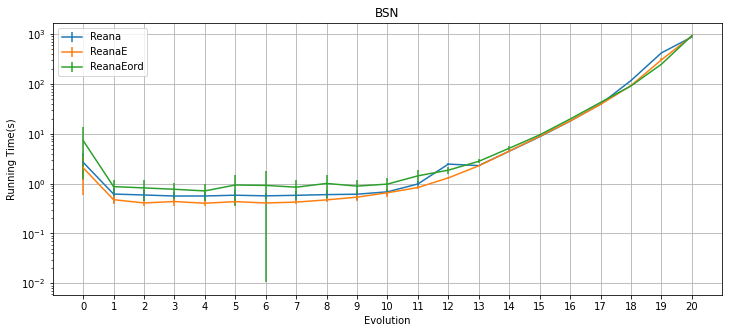

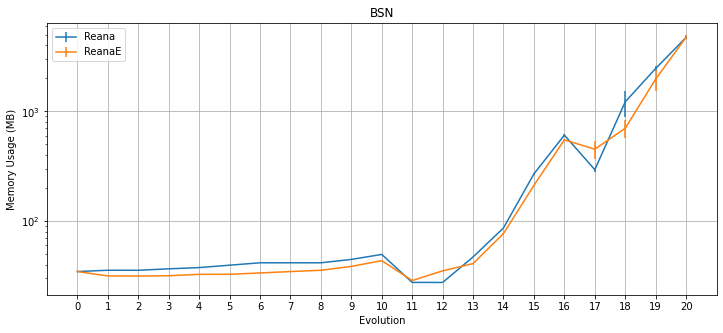

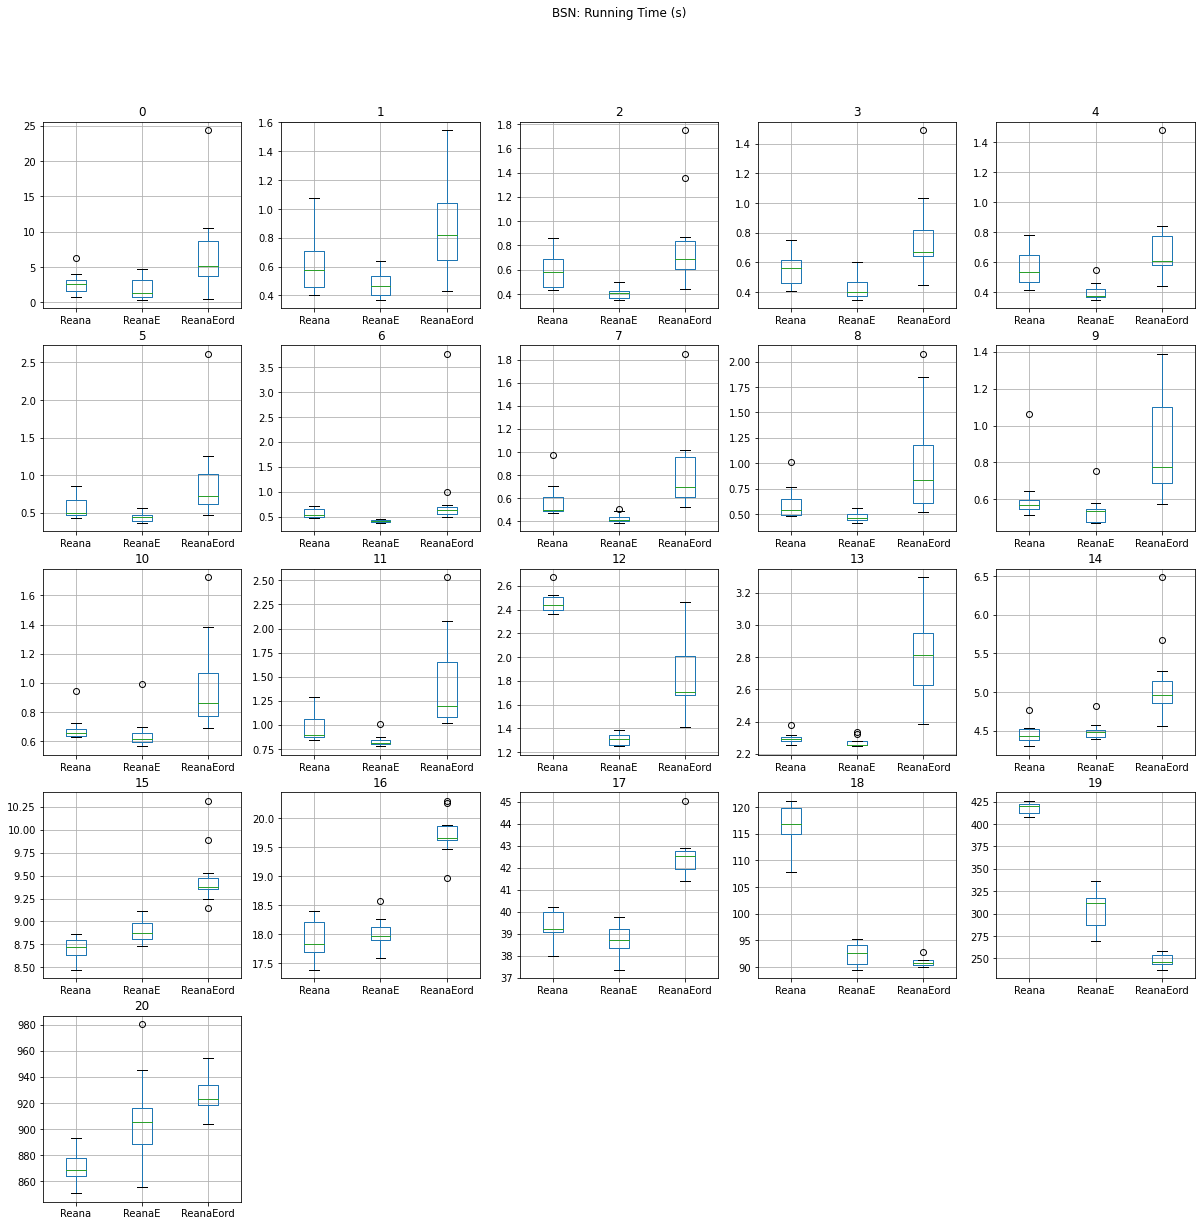

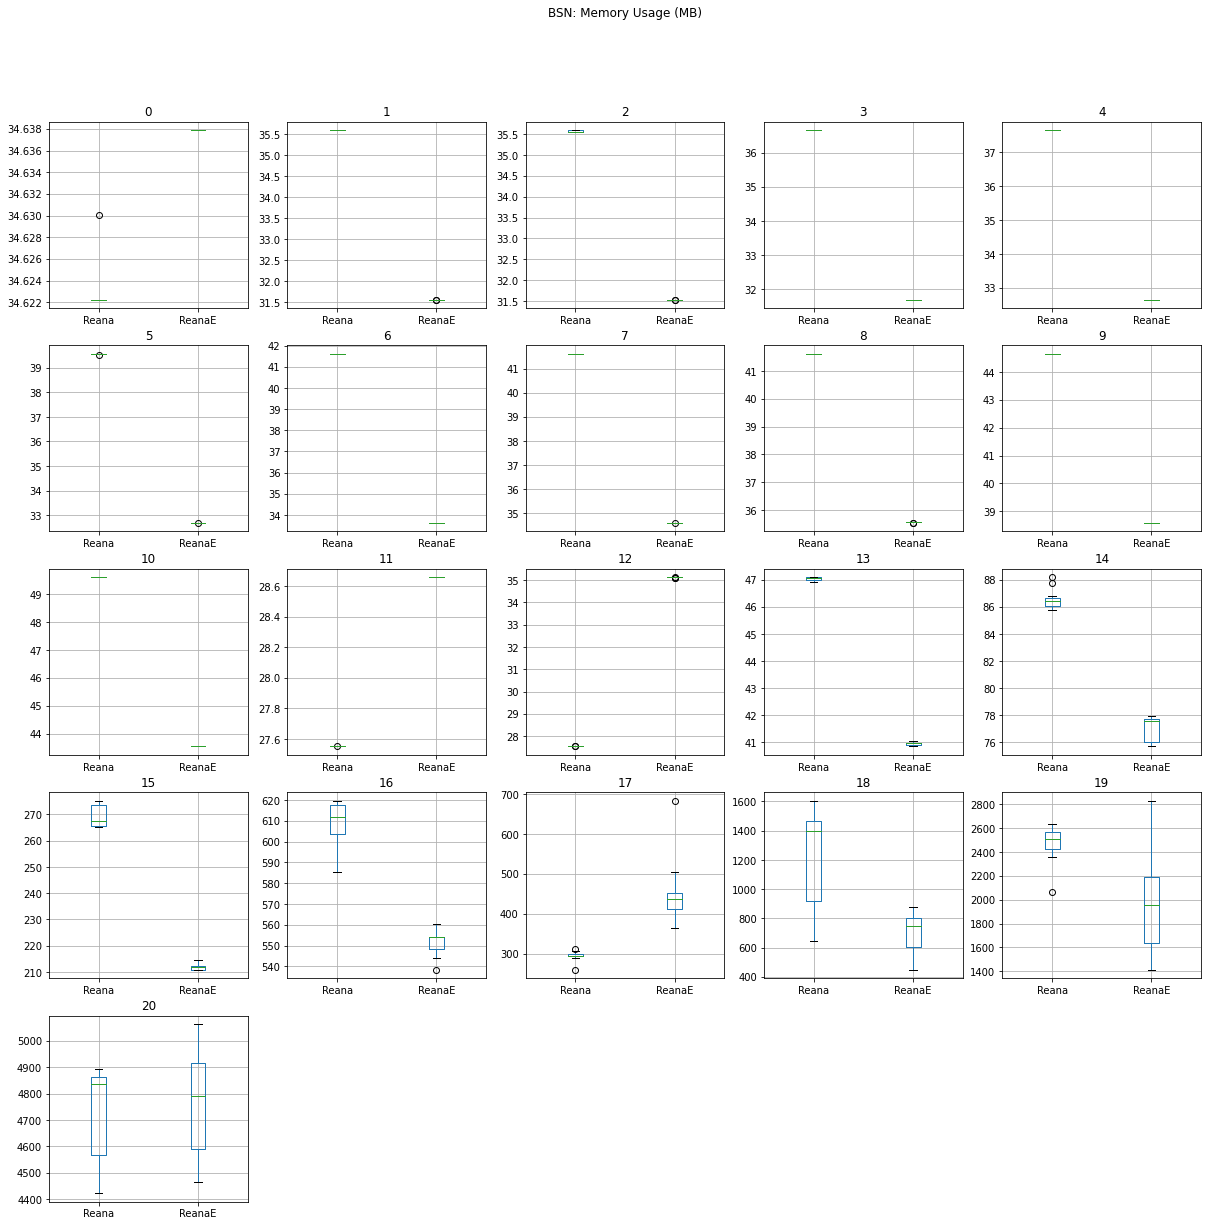

In [137]:
plot_spl('BSN')

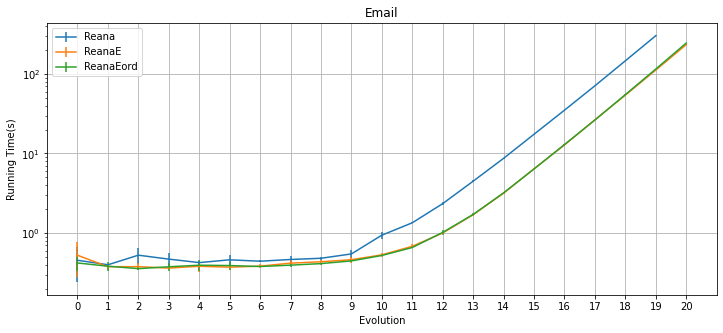

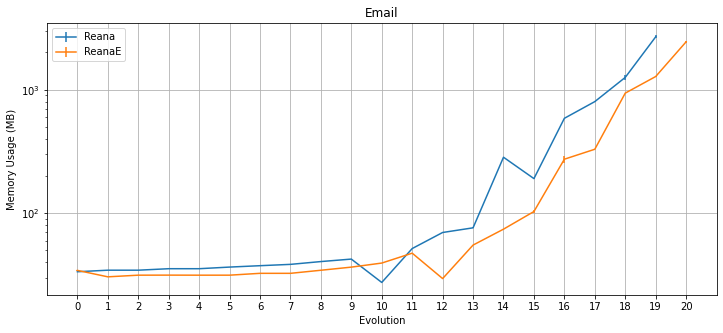

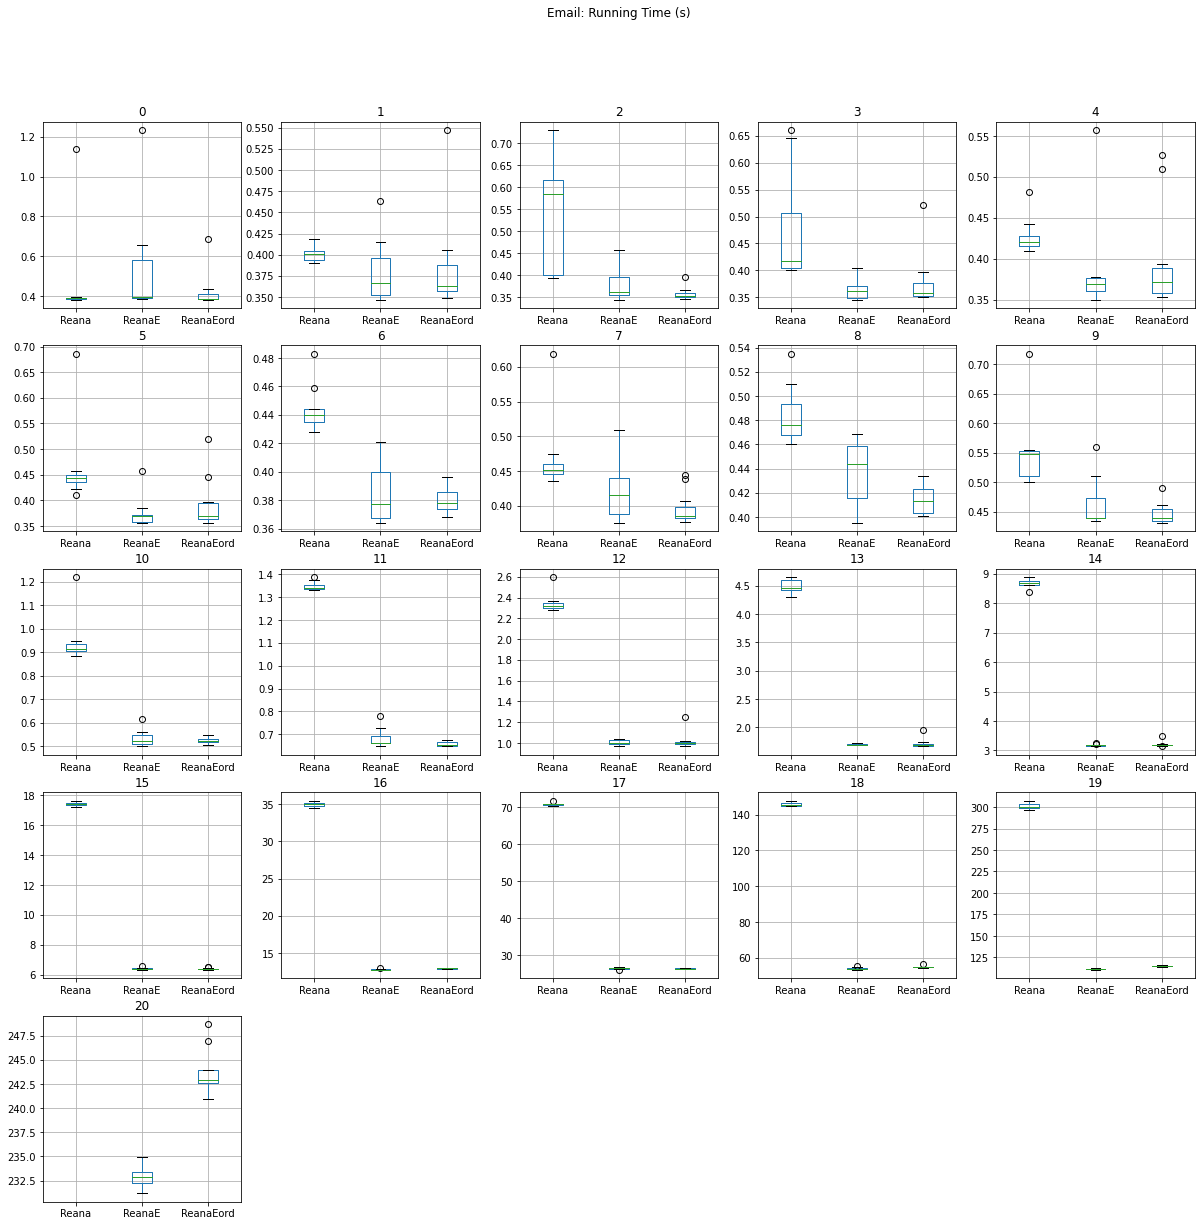

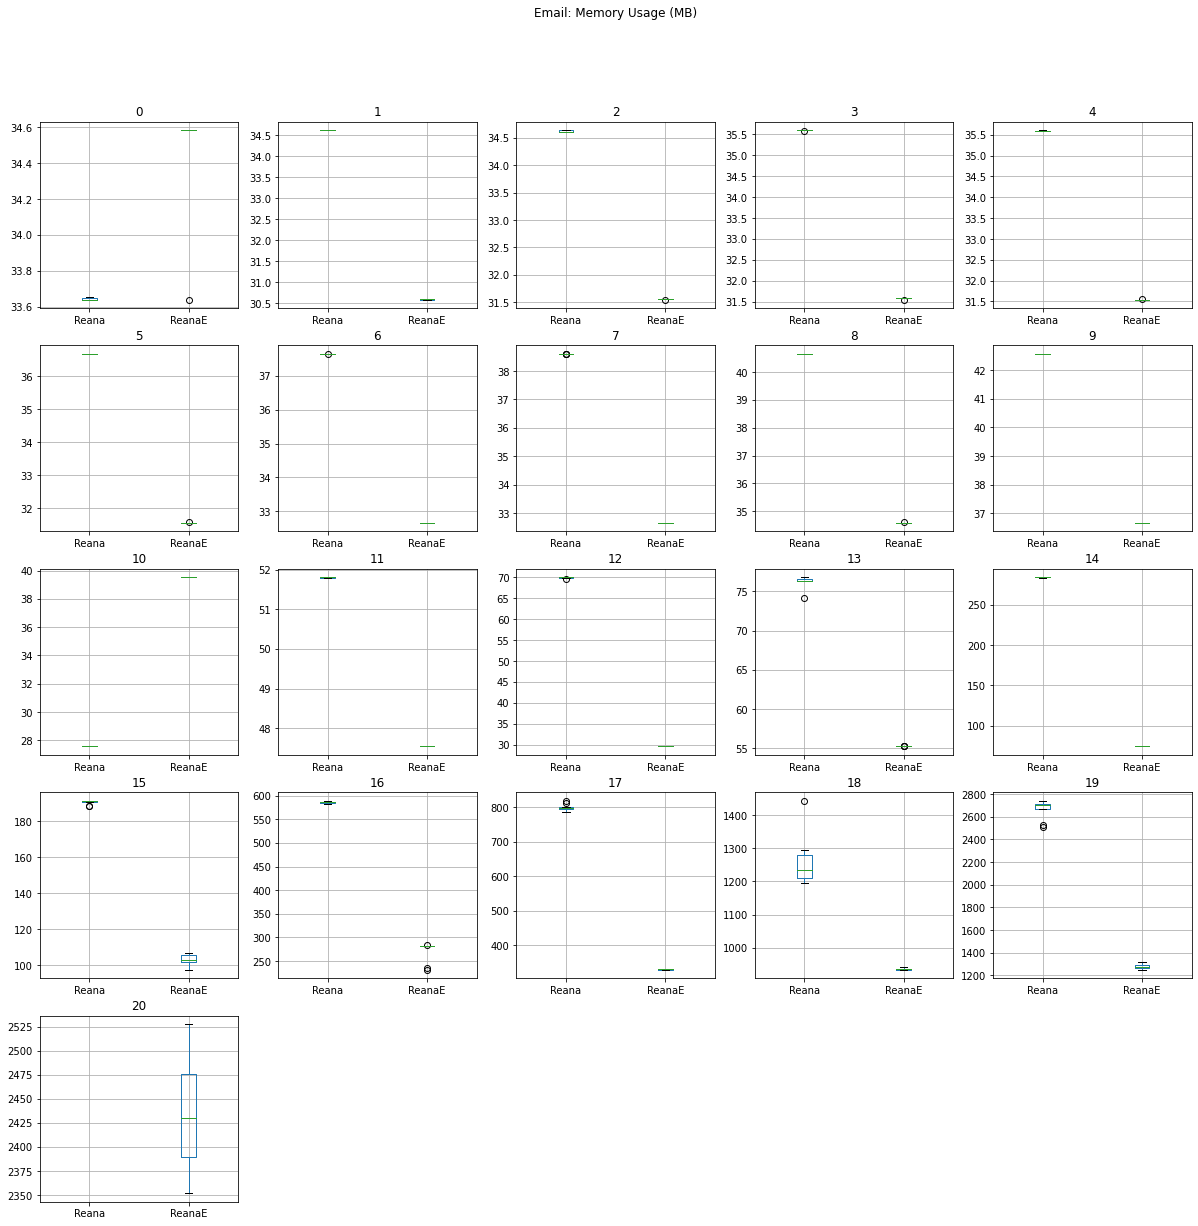

In [138]:
plot_spl('Email')

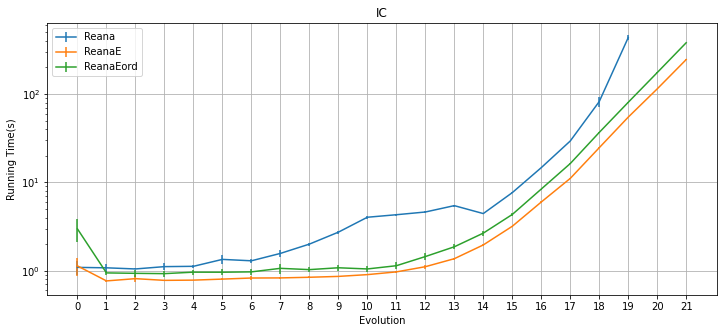

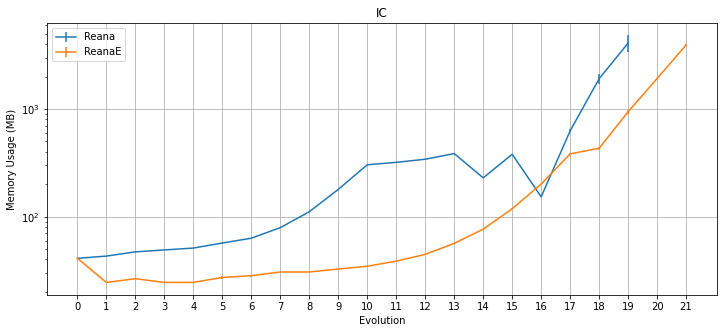

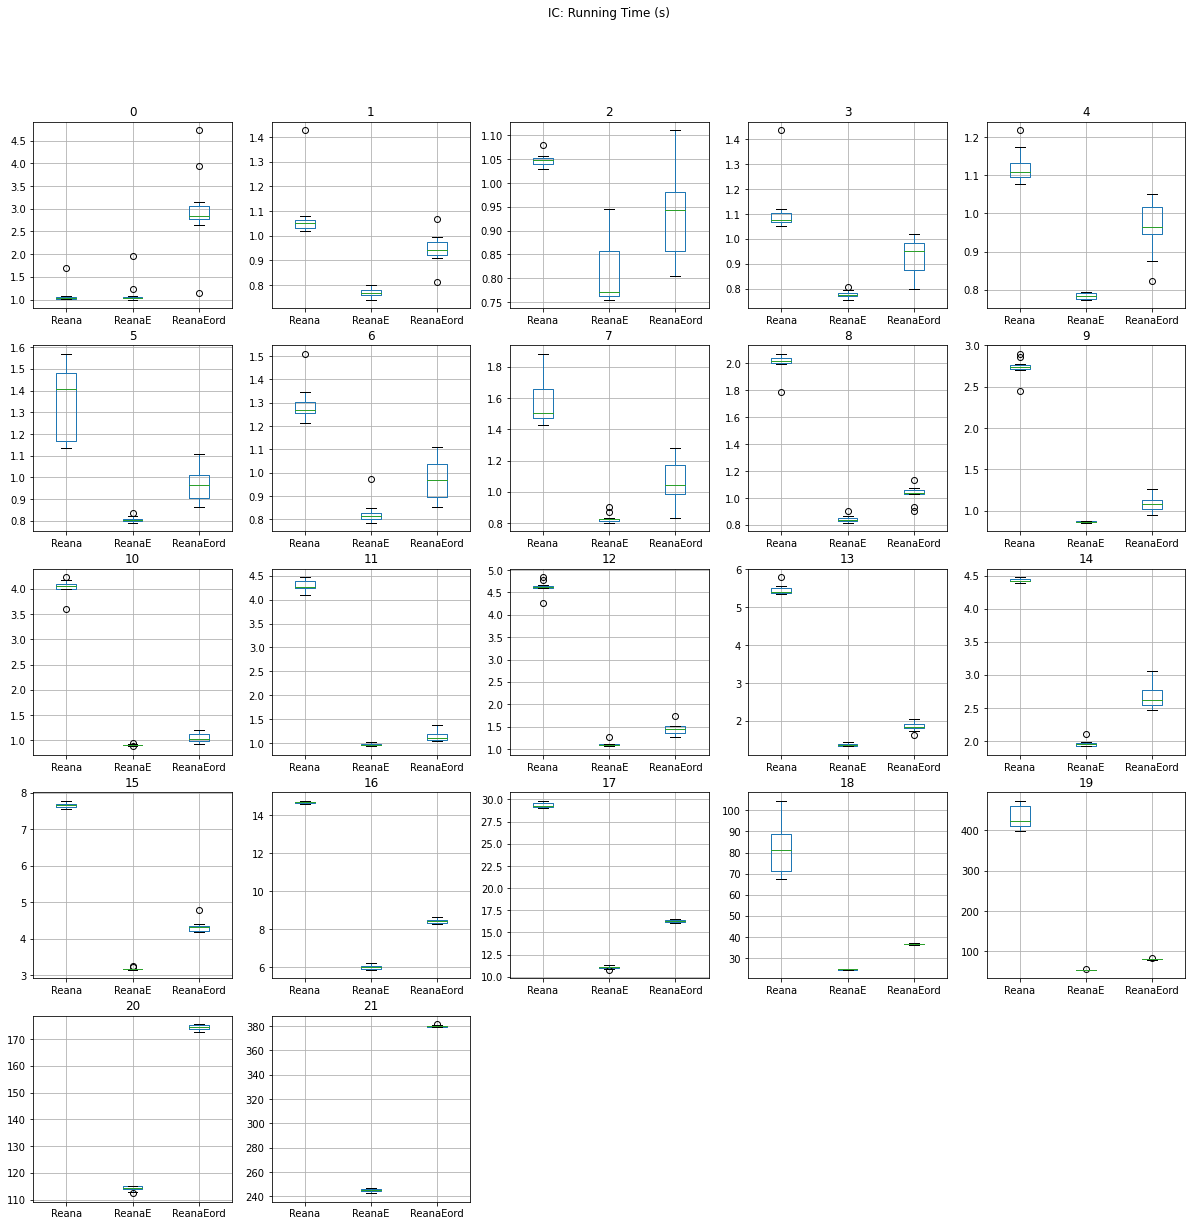

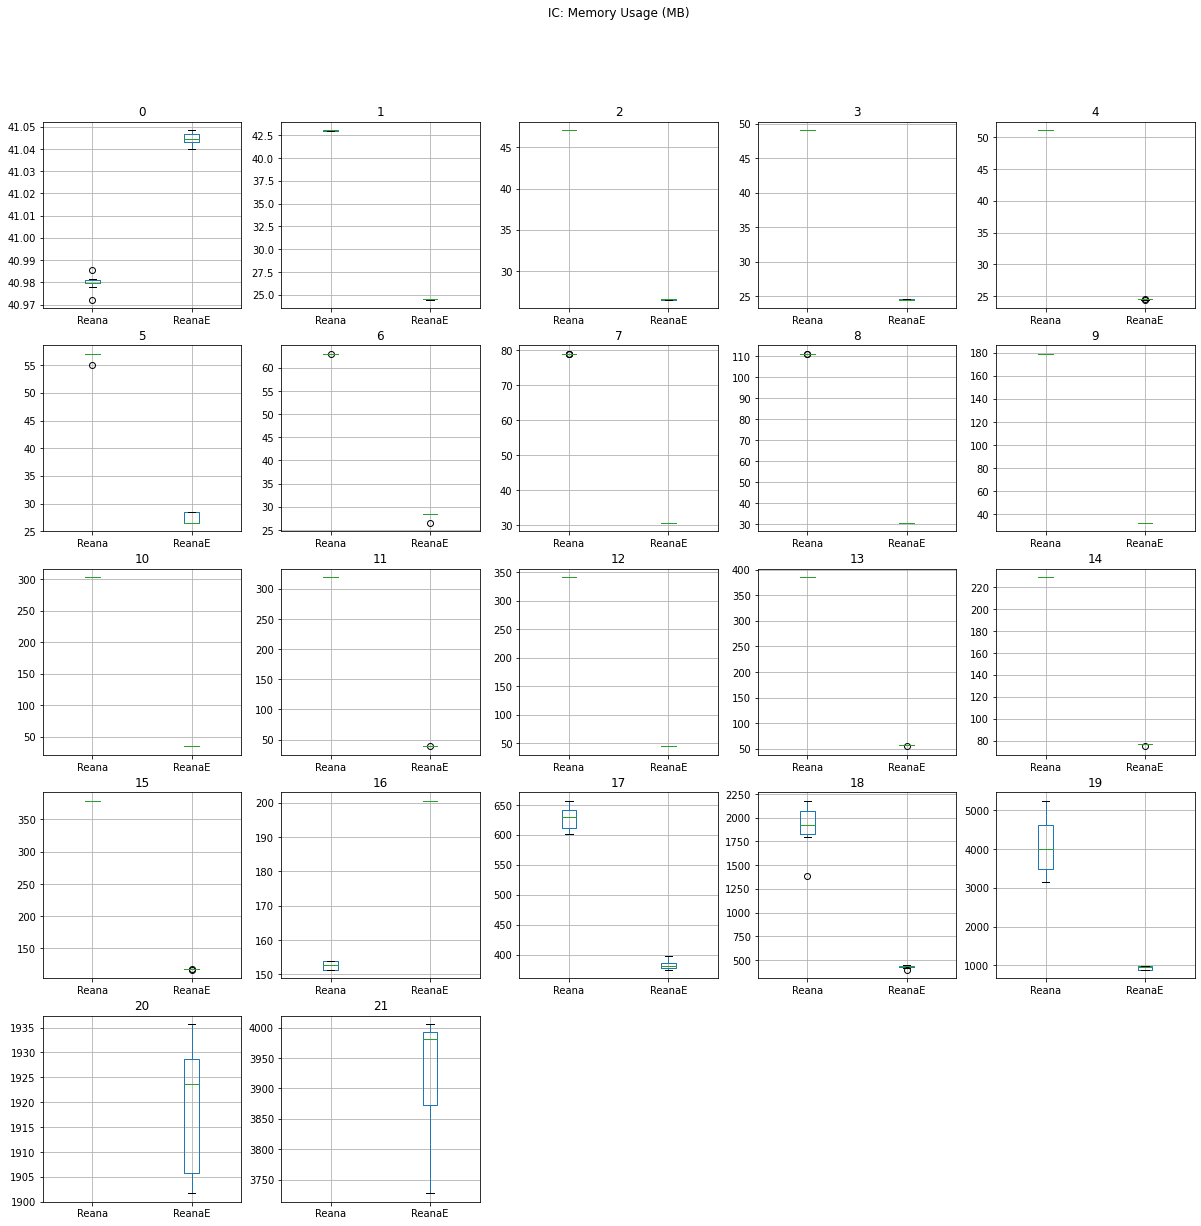

In [139]:
plot_spl('IC')

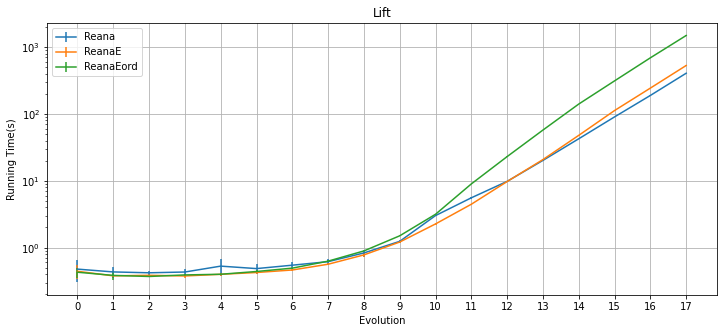

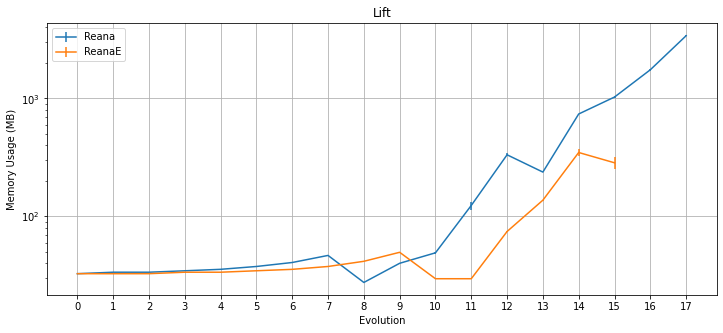

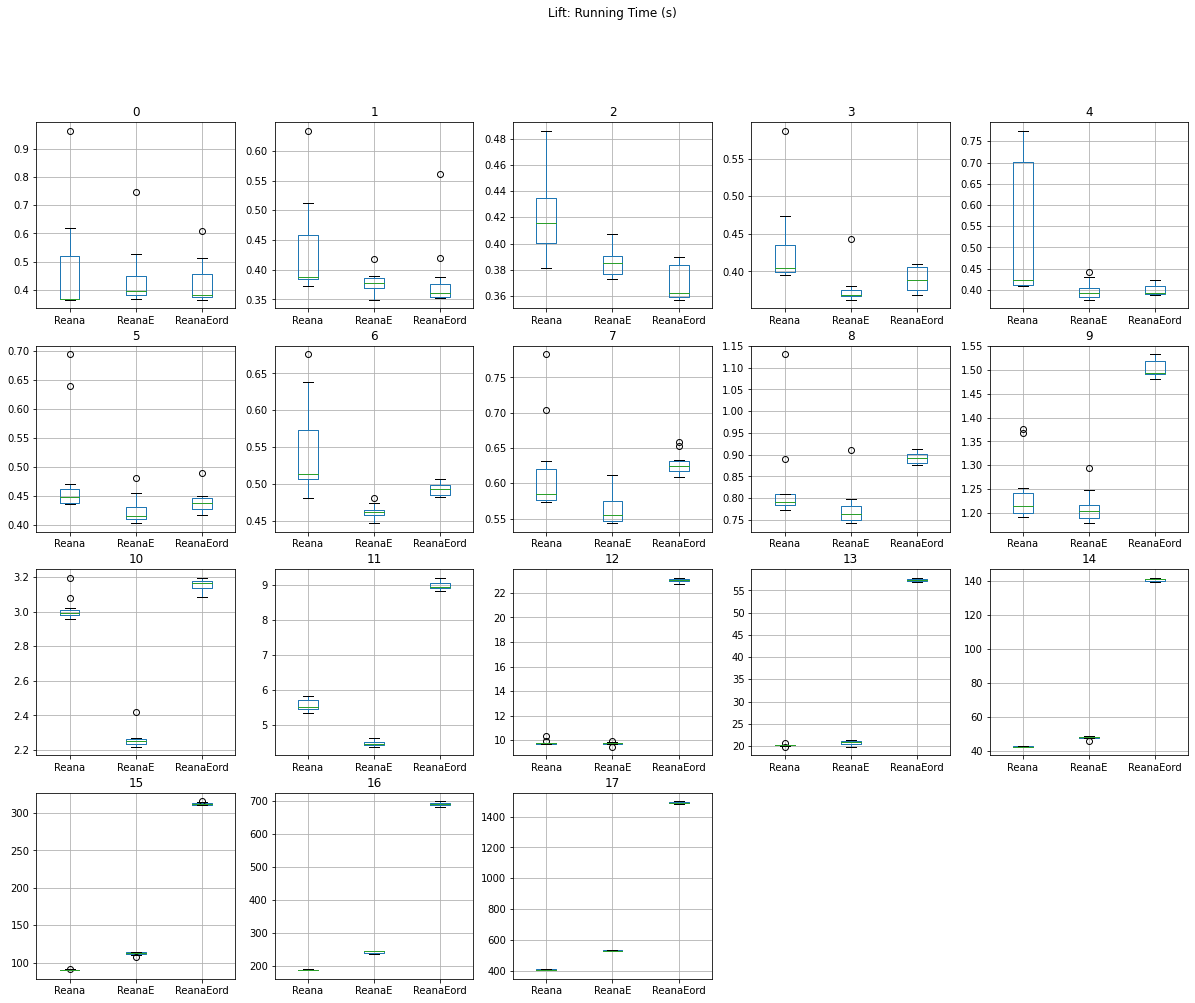

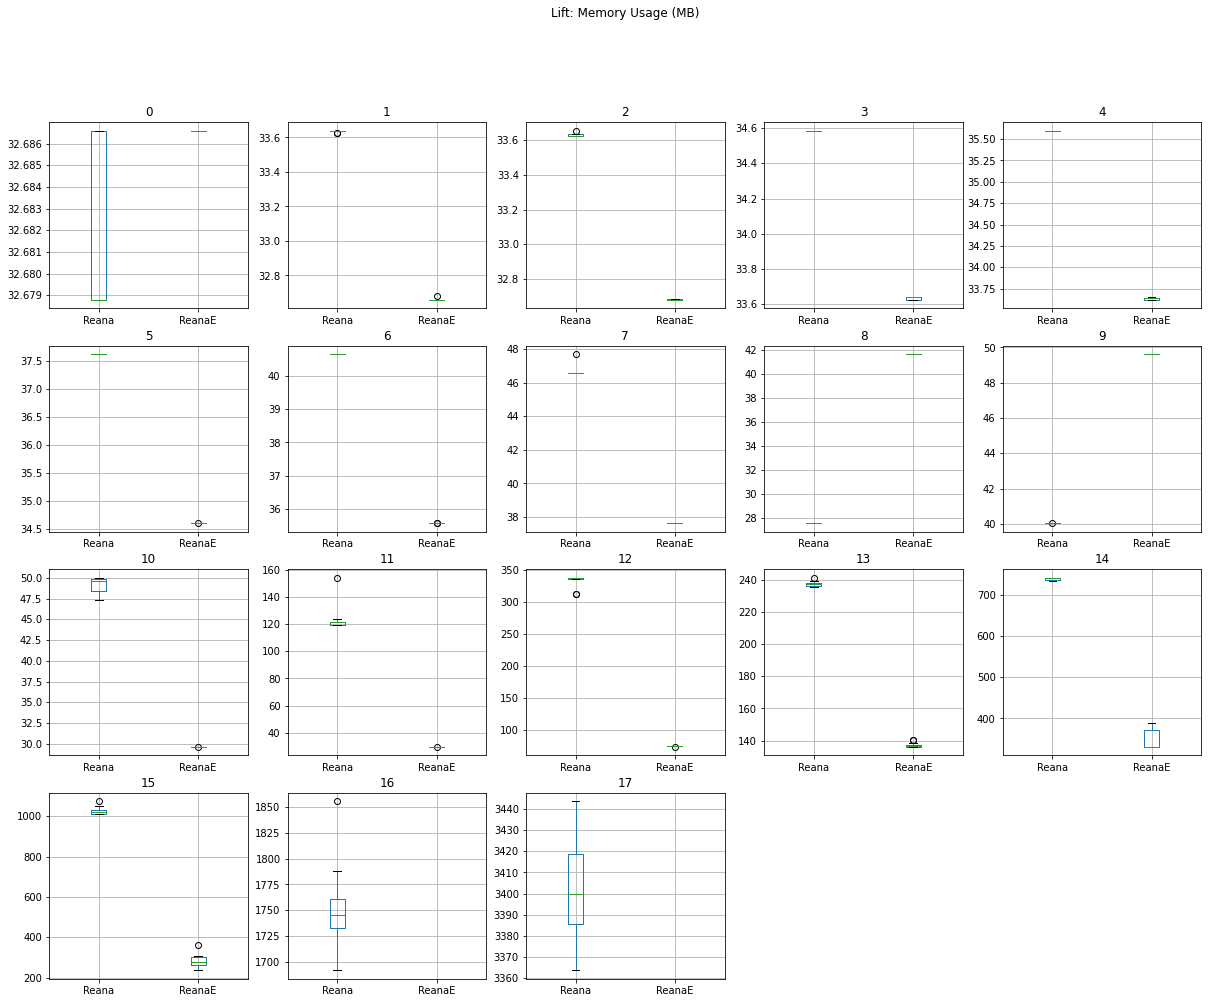

In [140]:
plot_spl('Lift')

In [141]:
plot_spl('MP')

ParserError: Error tokenizing data. C error: Expected 11 fields in line 2, saw 22


In [ ]:
plot_spl('TW')